<font size=5>**Turbofan engine Remaining Useful Lifetime prediction**</font>

![](../reports/figures/turbo.png)
![](../reports/figures/turbofan_schema.png)

### Import libraries

In [1]:
import glob
import numpy as np # scientifique computation
import pandas as pd # data manipulation
from matplotlib import pyplot as plt # dataviz
import seaborn as sns
%matplotlib notebook
%matplotlib inline
pd.options.display.max_columns = None

# split dataset & prepare 
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# feature engineering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

# pipeline
from sklearn.pipeline import Pipeline

# ML model
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# DL model
from sklearn.neural_network import MLPRegressor

# metrics evaluation
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
path_to_interim = '../data/interim/'
files = sorted(glob.glob(path_to_interim+'*'))

# upload dataset
df = pd.read_csv(files[0])

# choose relevant features
to_drop = ['engine_id', 'time_cycle', 'max_cycle'] # id/label cols
cst_features = ['op_set_3', 'sensor_18', 'sensor_19'] # constant features
quasi_cst_features = ['sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16'] # quasi-constant features
high_corr = ['sensor_9','sensor_14'] # core speed (sensor 9) & corrected core speed (sensor 14)
discreet_features = ['op_set_2', 'sensor_17']

# keep the ones to use for ML
cols_to_keep = [x for x in df.columns if x not in 
                to_drop + cst_features + quasi_cst_features + [high_corr[1]] + ['HI']]

# cols_to_keep_2 = [x for x in df.columns if x not in 
#                 to_drop + cst_features + quasi_cst_features + high_corr_to_drop + discreet_features]

In [3]:
df[cols_to_keep]

,op_set_1,op_set_2,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_15,sensor_17,sensor_20,sensor_21,RUL
0,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191
1,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190
2,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189
3,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188
4,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,-0.0004,-0.0003,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8.4956,397,38.49,22.9735,4
20627,-0.0016,-0.0005,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8.5139,395,38.30,23.1594,3
20628,0.0004,0.0000,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8.5646,398,38.44,22.9333,2
20629,-0.0011,0.0003,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8.5389,395,38.29,23.0640,1


In [4]:
# assign target and features
y = df['RUL']
X = df[cols_to_keep[:-2]]

# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# shape of train and test dataset
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(16504, 14) (4127, 14)
(16504,) (4127,)


In [5]:
def predict_y_RUL(pipe):
    
    # predict
    y_pred = pipe.predict(X_test)
    y_test.reset_index(drop=True)

    # create RUL df to compute error,d and score,s
    RUL = pd.concat([y_test.reset_index(drop=True), pd.Series(y_pred)], axis=1, ignore_index=True )
    RUL.rename(columns={0:'true', 1:'estimated'}, inplace=True)

    # cast as int
    RUL['estimated'] = [int(i) for i in RUL['estimated']]

    # compute error d
    RUL['error'] = RUL['estimated'] - RUL['true']
    
    # stock as RUL dataframe
    return RUL

In [6]:
# plot rul true vs estimated
def plot_rul_true_estimated(RUL):
    plt.figure(figsize=(6,6))
    sns.scatterplot(data=RUL, x='true', y='estimated', alpha=0.5)
    sns.lineplot(x=np.arange(-50,350), y=np.arange(-50,350), color = 'red')
    plt.xlim(-50,350)
    plt.ylim(-50,350)
    plt.grid()
    plt.show()

### Benchmark pipeline - Linear regression

In [7]:
# define steps
steps_lr = [('polynomial', PolynomialFeatures(2, interaction_only=True)),
            ('scaler', MinMaxScaler()),
            ('estimator', LinearRegression())]

pipe_lr = Pipeline(steps=steps_lr)

In [8]:
# fit
pipe_lr.fit(X_train, y_train)

# predict
pipe_lr.predict(X_test)

# scoring
print(f'R² score : {r2_score(y_test, pipe_lr.predict(X_test))}')
print(f'MSE      : {mean_squared_error(y_test, pipe_lr.predict(X_test))}')

R² score : 0.6102008002952546
MSE      : 1842.260970439618


In [9]:
# get rul dataframe
predict_y_RUL(pipe=pipe_lr)

,true,estimated,error
0,169,149,-20
1,112,72,-40
2,151,164,13
3,89,120,31
4,87,95,8
...,...,...,...
4122,29,23,-6
4123,32,51,19
4124,166,155,-11
4125,143,116,-27


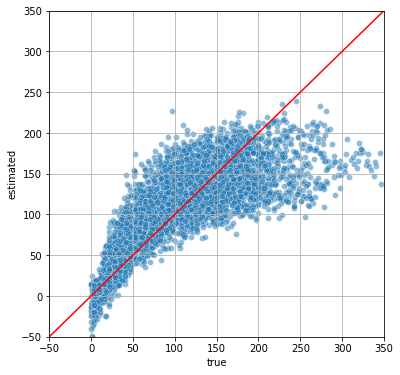

In [10]:
# plot rul
plot_rul_true_estimated(RUL=predict_y_RUL(pipe=pipe_lr))

### Pipeline - Support vector machine

In [11]:
# define pipeline steps
steps_svr = [('scaler', StandardScaler()),
            ('estimator', SVR())]

pipe_svr = Pipeline(steps=steps_svr)

In [12]:
# fit
pipe_svr.fit(X_train, y_train)

# predict
pipe_svr.predict(X_test)

# scoring
print(f'R² score : {r2_score(y_test, pipe_svr.predict(X_test))}')
print(f'MSE      : {mean_squared_error(y_test, pipe_svr.predict(X_test))}')

R² score : 0.600150033151503
MSE      : 1889.7626996528527


In [13]:
predict_y_RUL(pipe=pipe_svr)

,true,estimated,error
0,169,143,-26
1,112,57,-55
2,151,143,-8
3,89,125,36
4,87,94,7
...,...,...,...
4122,29,31,2
4123,32,45,13
4124,166,155,-11
4125,143,112,-31


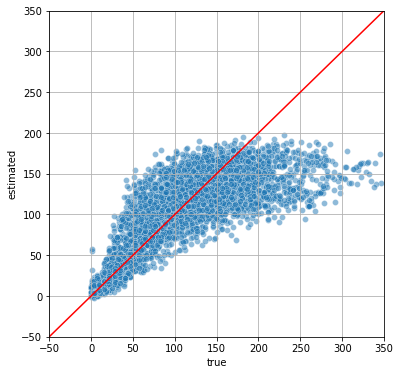

In [14]:
plot_rul_true_estimated(RUL=predict_y_RUL(pipe=pipe_svr))

### Pipeline - Multi-layer Perceptron

In [15]:
# define steps
steps_mlp = [('scaler', StandardScaler()),
            ('estimator', MLPRegressor(hidden_layer_sizes=(100,100), activation='tanh'))]

# instanciate pipeline
pipe_mlp = Pipeline(steps=steps_mlp)

In [16]:
# fit
pipe_mlp.fit(X_train, y_train)

# predict
pipe_mlp.predict(X_test)

# scoring
print(f'R² score : {r2_score(y_test, pipe_mlp.predict(X_test))}')
print(f'MSE      : {mean_squared_error(y_test, pipe_mlp.predict(X_test))}')

/home/hazmilh/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


R² score : 0.62762849459183
MSE      : 1759.8945596525944


In [17]:
predict_y_RUL(pipe=pipe_mlp)

,true,estimated,error
0,169,153,-16
1,112,51,-61
2,151,160,9
3,89,142,53
4,87,96,9
...,...,...,...
4122,29,25,-4
4123,32,50,18
4124,166,155,-11
4125,143,130,-13


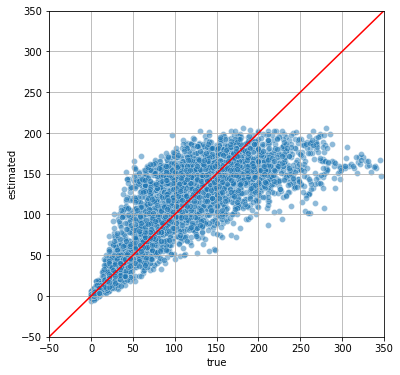

In [18]:
plot_rul_true_estimated(RUL=predict_y_RUL(pipe=pipe_mlp))

### Score comparisons

In [19]:
# R2 score
print(f'R² linear regression : {pipe_lr.score(X_test, y_test)}')
print(f'R² SVR               : {pipe_svr.score(X_test, y_test)}')
print(f'R² MLP               : {pipe_mlp.score(X_test, y_test)}')

R² linear regression : 0.6102008002952546
R² SVR               : 0.600150033151503
R² MLP               : 0.62762849459183


In [20]:
# mean square error
print(f'MSE linear regression : {mean_squared_error(y_test, pipe_lr.predict(X_test))}')
print(f'MSE SVR               : {mean_squared_error(y_test, pipe_svr.predict(X_test))}')
print(f'MSE MLP               : {mean_squared_error(y_test, pipe_mlp.predict(X_test))}')

MSE linear regression : 1842.260970439618
MSE SVR               : 1889.7626996528527
MSE MLP               : 1759.8945596525944


In [21]:
pipe_lr.get_params()

{'memory': None,
 'steps': [('polynomial', PolynomialFeatures(interaction_only=True)),
  ('scaler', MinMaxScaler()),
  ('estimator', LinearRegression())],
 'verbose': False,
 'polynomial': PolynomialFeatures(interaction_only=True),
 'scaler': MinMaxScaler(),
 'estimator': LinearRegression(),
 'polynomial__degree': 2,
 'polynomial__include_bias': True,
 'polynomial__interaction_only': True,
 'polynomial__order': 'C',
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'estimator__copy_X': True,
 'estimator__fit_intercept': True,
 'estimator__n_jobs': None,
 'estimator__normalize': False}

In [22]:
pipe_svr.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()), ('estimator', SVR())],
 'verbose': False,
 'scaler': StandardScaler(),
 'estimator': SVR(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'estimator__C': 1.0,
 'estimator__cache_size': 200,
 'estimator__coef0': 0.0,
 'estimator__degree': 3,
 'estimator__epsilon': 0.1,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False}

In [23]:
pipe_mlp.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('estimator',
   MLPRegressor(activation='tanh', hidden_layer_sizes=(100, 100)))],
 'verbose': False,
 'scaler': StandardScaler(),
 'estimator': MLPRegressor(activation='tanh', hidden_layer_sizes=(100, 100)),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'estimator__activation': 'tanh',
 'estimator__alpha': 0.0001,
 'estimator__batch_size': 'auto',
 'estimator__beta_1': 0.9,
 'estimator__beta_2': 0.999,
 'estimator__early_stopping': False,
 'estimator__epsilon': 1e-08,
 'estimator__hidden_layer_sizes': (100, 100),
 'estimator__learning_rate': 'constant',
 'estimator__learning_rate_init': 0.001,
 'estimator__max_fun': 15000,
 'estimator__max_iter': 200,
 'estimator__momentum': 0.9,
 'estimator__n_iter_no_change': 10,
 'estimator__nesterovs_momentum': True,
 'estimator__power_t': 0.5,
 'estimator__random_state': None,
 'estimator__shuffle': True,
 'estimator__solver': 'adam',
 'estimator__tol': 0

### Visualization

In [24]:
RUL_lr = predict_y_RUL(pipe=pipe_lr)
RUL_svr = predict_y_RUL(pipe=pipe_svr)
RUL_mlp = predict_y_RUL(pipe=pipe_mlp)

plt.figure(figsize=(6,6))

sns.scatterplot(data=RUL_lr, x='true', y='estimated', alpha=0.25, color='blue')
sns.scatterplot(data=RUL_svr, x='true', y='estimated', alpha=0.25, color='green')
sns.scatterplot(data=RUL_mlp, x='true', y='estimated', alpha=0.25, color='gray')

sns.lineplot(x=np.arange(-50,350), y=np.arange(-50,350), color = 'red')
plt.xlim(-50,350)
plt.ylim(-50,350)
plt.grid()
plt.show()

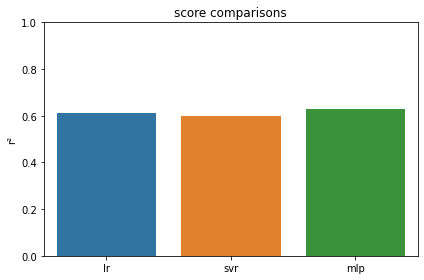

In [35]:
plt.figure(figsize=(6,4))
plt.title('score comparisons')

scores = [pipe_lr.score(X_test, y_test),
          pipe_svr.score(X_test, y_test),
          pipe_mlp.score(X_test, y_test)
         ]

sns.barplot(y=scores, x=['lr', 'svr', 'mlp'])
plt.ylim(0,1)
plt.ylabel('r²')
plt.tight_layout()
plt.show()

In [31]:
print(f'R² linear regression : {pipe_lr.score(X_test, y_test)}')
print(f'R² SVR               : {pipe_svr.score(X_test, y_test)}')
print(f'R² MLP               : {pipe_mlp.score(X_test, y_test)}')

print(f'MSE linear regression : {mean_squared_error(y_test, pipe_lr.predict(X_test))}')
print(f'MSE SVR               : {mean_squared_error(y_test, pipe_svr.predict(X_test))}')
print(f'MSE MLP               : {mean_squared_error(y_test, pipe_mlp.predict(X_test))}')

R² linear regression : 0.6102008002952546
R² SVR               : 0.600150033151503
R² MLP               : 0.62762849459183
MSE linear regression : 1842.260970439618
MSE SVR               : 1889.7626996528527
MSE MLP               : 1759.8945596525944
